In [1]:
import os
import numpy as np
import pandas
import seaborn

from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import stats

from sklearn import svm, model_selection, metrics
# from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
%matplotlib inline

from pocs.utils.jupyter import widgets

# Classification

Classification is about creating a way to classify or label unknown data based off of existing labeled data. The idea is that you should be able to classify a certain amount of your data (either via the hard work of dedicated graduates students or through naive and willing members of the public, e.g. Galaxy Zoo)

## The Process:

1. Get some data
2. Pick your features!
3. Separate the data
4. Find a kernel (for your SVM, of course!)
5. Classify! For fun and profit!
6. Analyze (Did it work?)

### 1. Get Data

Ideally you would have some labelled and unlabelled data. Here we want to test classifiers so we grab a whole bunch of labelled data and then just pretend we don't know the labels for some of them.

The data we are working with are variable stars. There are many types of variable stars but we only try to classify between the periodic.

Data is obatained from the Catalina Sky Survey (http://catalinadata.org).

In [2]:
# Load our matched data from the catalog
cat_data = 'catalog_data_final/matched_data.csv'

In [3]:
# Number of rows
!wc -l $cat_data

1436659 catalog_data_final/matched_data.csv


In [4]:
catalog = pandas.read_csv(cat_data, index_col=0, usecols=[1,2,3,7,10,11,12,13,14,15,16,17])

# Filter and scrub
catalog = catalog[catalog['Blend'] == 0]
catalog.rename(columns={
        'V_(mag)': 'V_mag', 
        'Period_(days)': 'Period', 
        'Var_Type': 'Class', 
        'RA_(J2000)': 'RA',
}, inplace=True)

In [5]:
catalog.head()

,Mag,Magerr,Blend,RA,Dec,V_mag,Period,Amplitude,Number_Obs,Class,epoch folding
ID,,,,,,,,,,,
1109019013189,12.24,0.05,0,03:29:14.70,+09:11:20.2,12.58,0.446914,0.31,192,1,0.432202
1109019013189,12.28,0.05,0,03:29:14.70,+09:11:20.2,12.58,0.446914,0.31,192,1,0.067618
1109019013189,12.26,0.05,0,03:29:14.70,+09:11:20.2,12.58,0.446914,0.31,192,1,0.078448
1109019013189,12.25,0.05,0,03:29:14.70,+09:11:20.2,12.58,0.446914,0.31,192,1,0.089300
1109019013189,12.30,0.05,0,03:29:14.70,+09:11:20.2,12.58,0.446914,0.31,192,1,0.100153


### 2. Pick Features

Feature selection is an important part of classification. Unfortunately there is no systematic way to select these features. To some extent this is where the science can come in. In my case I just guess. Really we just use what is available in the data.  Our features will be:

* Magnitude (median)
* Period
* Amplitude
* Skew
* IQR (interquantile range)

In [6]:
def setup_features():
    data = {
        'class': [],
        'predicted': [],
        'ra': [],
        'dec': [],
        'period': [],
        'mag': [],
        'mag_median': [],
        'amplitude': [],
        'skew': [],
        'iqr': [],
    }
    unique_id = catalog.index.unique()
    for uid in widgets.log_progress(unique_id):
            rows = catalog.loc[uid]

            data['class'].append(rows['Class'].iloc[0])
            data['predicted'].append(0)

            ra = rows['RA'].iloc[0]
            dec = rows['Dec'].iloc[0]
            coord = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
            data['ra'].append(coord.ra.value)
            data['dec'].append(coord.dec.value)

            data['period'].append(rows['Period'].iloc[0])
            data['mag'].append(rows['Mag'].iloc[0])
            data['mag_median'].append(np.median(rows['Mag']))
            data['amplitude'].append(rows['Amplitude'].iloc[0])
            data['skew'].append(stats.skew(rows['Mag']))
            data['iqr'].append(np.percentile(rows['Mag'], 75) - np.percentile(rows['Mag'], 25))

    features = pandas.DataFrame(data, index=unique_id)
    features.index.name = 'ID'
    
    # Write to CSV to save time
    features.to_csv('features.csv')
    
    return features

In [7]:
# Get our features from the file or build them
if not os.path.exists('features.csv'):
    features = setup_features()
else:
    features = pandas.read_csv('features.csv', index_col=0)

In [8]:
features_copy = features.copy()
# Remove meta information
try:
    del features['dec']
#     del features['predicted']
    del features['ra']
    del features['mag']
except:
    pass

In [9]:
features.head()

,amplitude,class,iqr,mag_median,period,predicted,skew
ID,,,,,,,
1109019013189,0.31,1,0.24,12.370,0.446914,0,0.208991
1118018023786,0.48,1,0.23,14.470,0.270987,0,0.687586
1104019012100,0.75,1,0.27,16.820,0.301688,0,0.837339
1132016011828,0.25,1,0.17,15.500,0.427316,0,-0.077371
1129017071021,0.32,1,0.18,15.015,17.242100,0,0.618961


### 3 Separate Data

We need three groups of data: training, testing, and unknown. In our case the unknown is really known but we are just pretending. The training and testing data is the labelled and known data. Ideally you want to train on about 2/3 of the known data and then test the remaining 1/3 to make sure your classifier is working ok. However, exactly how much you want to train on can affect the results.

#### 3.1 Separate Labelled and Unlabelled Data

To start, we use a poor-man's version of the holdout method (e.g. hold some of them out) to split the initial set of data into labelled and unlablled. For simplicity we just use 75% of the data for training

In [10]:
# Start to build the table we will use

# For Training data, we want to get a certain amount of our
# table, we slice off a percentage
row_start = 0
row_end = len(features) - int(.25 * len(features))

# Our collections of data to train and test
labeled_svm = features.iloc[row_start:row_end]
unlabeled_svm = features.iloc[row_end:]
test_all = features.iloc[row_end:]

# The correct classes corresponding to the training and test
classes = labeled_svm['class']
unlabeled_classes = unlabeled_svm['class']

# Remove the labels
del labeled_svm['class']
del unlabeled_svm['class']

In [11]:
labeled_svm.head()

,amplitude,iqr,mag_median,period,predicted,skew
ID,,,,,,
1109019013189,0.31,0.24,12.370,0.446914,0,0.208991
1118018023786,0.48,0.23,14.470,0.270987,0,0.687586
1104019012100,0.75,0.27,16.820,0.301688,0,0.837339
1132016011828,0.25,0.17,15.500,0.427316,0,-0.077371
1129017071021,0.32,0.18,15.015,17.242100,0,0.618961


In [12]:
types = { 1: 'EW', 2: 'EA', 3: 'beta Lyrae'}

# How many of each Variable Type do we have
print("Type\t\t\tType\t\tNumber".format())
print("{}".format('-'*45))
for x in range(1,4):
    print("Labeled Class size:\t {:14s} {}".format(types[x],len(classes[classes == x])))
    print("Unlabeled Class size:\t {:14s} {}\n".format(types[x],len(unlabeled_classes[unlabeled_classes == x])))
    
print("{}".format('-'*45))    
print('Labeled Total: \t\t\t\t{}'.format(len(labeled_svm)))
print('Unlabeled Total: \t\t\t{}'.format(len(unlabeled_svm)))

Type			Type		Number
---------------------------------------------
Labeled Class size:	 EW             2938
Unlabeled Class size:	 EW             986

Labeled Class size:	 EA             411
Unlabeled Class size:	 EA             124

Labeled Class size:	 beta Lyrae     26
Unlabeled Class size:	 beta Lyrae     15

---------------------------------------------
Labeled Total: 				3375
Unlabeled Total: 			1125


### 3.2 Determine Training Size

Now that we have some labelled data we need to split that data into training data and test data. While 2/3 to 1/3 for training to test is a good initial estimate, we can do some work to determine the best size by trying different classifiers

First we create a simple linear classifier and fit the labelled data to the known classes

In [13]:
# Create our (linear) classifier
clf = svm.LinearSVC()
clf.fit(labeled_svm, classes)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

First use a simple `train_test_split` with a `test_size` of 1/3. This will give us some testing and training data (both dependent and independent sets)

In [14]:
# Do an auto split
X_train, X_test, y_train, y_test = model_selection.train_test_split (labeled_svm, classes, test_size=1./3.)

print("training set = {} {}".format(X_train.shape, y_train.shape))
print("test size = {} {}".format(X_test.shape, y_test.shape))

# Fit to our training data to the linear classifier
clf.fit(X_train, y_train)

# Get prediction for test data
pred_class = clf.predict(X_test)

# Determine matches
N_match = (pred_class == y_test).sum()
print("N_match = {}".format(N_match))

# Accuracy
acc = 1. * N_match / len(pred_class)
print("Accuracy = {}".format(acc))

training set = (2250, 6) (2250,)
test size = (1125, 6) (1125,)
N_match = 1032
Accuracy = 0.9173333333333333


We can also use a slightly more fancy version for (sometimes) better results:

In [15]:
ss = model_selection.StratifiedShuffleSplit(test_size = 1./3.)
scores = model_selection.cross_val_score(clf, labeled_svm, classes, cv=ss)
print("Accuracy = {} +- {}".format(scores.mean(),scores.std()))

Accuracy = 0.9224888888888888 +- 0.0043510180446294806


You and your friends can test out all of the available splitter classes here: http://scikit-learn.org/stable/modules/classes.html#splitter-classes

We can also test a whole bunch of training sizes and plot them

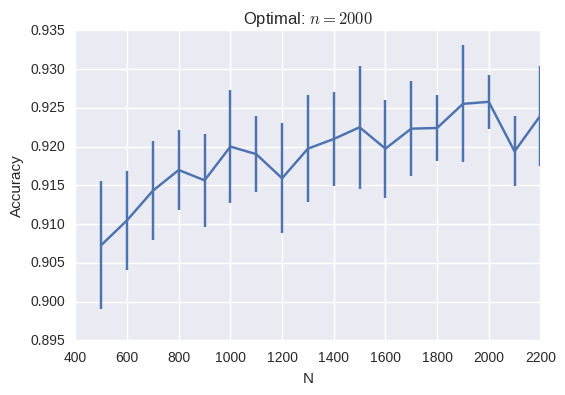

In [16]:
step = 100
stop = int(len(labeled_svm) * (2./3.))
Ns = np.arange(500, stop , step)

scores = np.zeros(len(Ns))
stds = np.zeros(len(Ns))
for i in range(len(Ns)):
    N = Ns[i]
    ss = model_selection.StratifiedShuffleSplit(test_size = 1./3., train_size = N)
    scores_i = model_selection.cross_val_score(clf, labeled_svm, classes, cv=ss)
    scores[i] = scores_i.mean()
    stds[i] = scores_i.std()

    
# Get our optimal n
optimal_n = Ns[np.argmax(scores)]
    
# Plot our results, including optimal n
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar (Ns, scores, yerr = stds)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
plt.title("Optimal: $n={}$".format(optimal_n))    
plt.show()

### 4. Pick your SVC (Support Vector Classification)

There are a number of possible different classifiers that are available but the classifiers _du jour_ are all Support Vector Machines (SVM). However, even with an SVM there is the decision of which kernel to use. Luckily these can be tested.

We use the sklean.svm.svc module with a few different kernels to attempt some fits.

#### Determine Best Kernel Classifier

Run through the different kernels for an SVC to determine the best. Possible kernels are:
    
* linear
* poly 
* rbf
* sigmoid
* precomputed
    
We perform an exhaustive grid search across all the kernels with a range of different values. We compute these separately so that we can then compare each with an ROC. The grid search would handle this internally if we ran them all together but we want to generate an ROC plot so we do it separate.

#### Get the optimal SVC

Here we define the parameters for each of the kernel types and then run them through an exhaustive grid search. This is similar to the examples above where we ran through a list of $C$ and $\gamma$ values but here the `GridSearchCV` takes care of all the details. This gets us our optimal classifier based on this exhaustive search.

One area of uncertainty is the selection of our ranges below. We lifted the $C$ and $\gamma$ ranges from Guillermo's Hands-On (_todo: get reference_) and just copied that over for the coefficient range. We totall guessed at the degree range and would need to explore that more.

In [17]:
def get_optimal_svc(param_grid=list(), plot=False):
    
    # Do the grid search
    grid = model_selection.GridSearchCV(svm.SVC(), param_grid=param_grid, cv=ss)
    grid.fit (labeled_svm, classes)
    
    if plot:
        score_dict = grid.cv_results_
        
        # We extract the scores
        scores = np.array([x[1] for x in score_dict])
        scores = scores.reshape(len(C_range), len(gamma_range))

        # Make a nice figure
        plt.figure(figsize=(8, 6))
        plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
        plt.imshow(scores, interpolation='nearest', cmap=plt.cm.gist_heat)
        plt.xlabel('$\gamma$')
        plt.ylabel('$C$')
        plt.title('Heatmap for optimal: $C={}$ and $\gamma={}$\n'.format(grid.best_estimator_.C, grid.best_estimator_.gamma))
        plt.colorbar()
        plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
        plt.yticks(np.arange(len(C_range)), C_range)
        plt.show()

    print("The best classifier for this run is: {}".format(grid.best_estimator_))
    return grid.best_estimator_

_**Note: This takes a long time **_

In [18]:
# Setup our ranges
C_range = 10. ** np.arange(-4, 4)
gamma_range = 10. ** np.arange(-4, 4)
deg_range = np.arange(1, 3)
coef_range = 10. ** np.arange(-4, 4)

param_grids = [
#     { 'C': C_range, 'kernel': ['linear'] },
#     { 'C': C_range, 'gamma': gamma_range, 'degree': deg_range, 'coef0': coef_range, 'kernel': ['poly'] },
    { 'C': C_range, 'gamma': gamma_range, 'kernel': ['rbf'] },
#     { 'C': C_range, 'gamma': gamma_range, 'coef0': coef_range, 'kernel': ['sigmoid'] },
    
    { 'kernel': ['linear'] },
    { 'kernel': ['poly'] },
    { 'kernel': ['sigmoid'] },
]

best_svcs = list()

# Run the param_grid one at a time (to compare ROC below)
# Get the best clf for each kernel type
for param_grid in param_grids:
    print("{}...".format(param_grid.get('kernel')))
    clf = get_optimal_svc(param_grid=param_grid, plot=False)
        
    param_grid['clf'] = clf
    
    best_svcs.append(param_grid)

['rbf']...
The best classifier for this run is: SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
['linear']...
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
['poly']...
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
['sigmoid']...
The best classifier for this run is: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='si

### 5. Classify

We have obtained our best classifiers above, so we classify the data with each. We will then compare how these classifiers worked with a ROC.

First we define our `classify` and `compute_roc` functions and then use them below.

In [19]:
def classify(clf=None, save_output=False):

    # Use the best estimator from above and fit with our trained data and classes
    clf.fit(labeled_svm, classes)

    # Attempt a prediction
    predicted_classes = clf.predict(unlabeled_svm)

    if save_output:
        # Creating an array to hold our new predicted values
        out = np.zeros ((len(pred_class), unlabeled_svm.shape[1] + 1))
        out[:,:unlabeled_svm.shape[1]] = unlabeled_svm[:][:]
        out[:, -1] = predicted_classes [:]

        classifications_filename = "classifications_predicted_{}.csv".format(clf.kernel)
        
        # Save our new classifications out to a file
        np.savetxt(classifications_filename, out, delimiter=",")
    
    return predicted_classes

In [20]:
def compute_roc(predicted_classes=None):
    # Get our mask array of true values
    predicted_correct_mask = np.array(unlabeled_classes == predicted_classes)

    # Get the scores from the classifier
    y_score = clf.decision_function(unlabeled_svm)

    # Perform the ROC to get false-positives and true-positives
    fpr, tpr, thresh =  metrics.roc_curve(predicted_correct_mask,y_score[:,0])
    roc_auc = metrics.auc(fpr,tpr)
    
    return fpr, tpr, roc_auc

In [21]:
# Loop over each SVC type, classify, then compute the ROC
for kernel in best_svcs:
    clf = kernel.get('clf')

    print("{} ".format(clf.kernel))

    # Do the actual classifying
    print("\t Classifying...")
    pred_class = classify(clf)
    
    # Compute the ROC
    print("\t Compute ROC...")
    fpr, tpr, auc = compute_roc(pred_class)
    
    # Store the predicted classes and the ROC params
    kernel['predicted_classes'] = pred_class
    kernel['fpr'] = fpr
    kernel['tpr'] = tpr
    kernel['auc'] = auc    

rbf 
	 Classifying...
	 Compute ROC...
linear 
	 Classifying...


/home/wtgee/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:552: ChangedBehaviorWarning: The decision_function_shape default value will change from 'ovo' to 'ovr' in 0.19. This will change the shape of the decision function returned by SVC.
  "SVC.", ChangedBehaviorWarning)


	 Compute ROC...
poly 
	 Classifying...
	 Compute ROC...
sigmoid 
	 Classifying...
	 Compute ROC...


#### ROC Curve
Here we determine which classifier was the "best" via an ROC Curve.

_NOTE: We could have just performed the exhaustive grid search above and it would have automatically compared all of these and output the absolute best, but because we wanted to generate an ROC we performed them separately._

In [22]:
def plot_roc(classifier_list=None):
    # Plot the ROC for each kernel type
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    # Add a line for each kernel
    for classifier in classifier_list:
        fpr = classifier['fpr']
        tpr = classifier['tpr']
        auc = classifier['auc']
        ax.plot (fpr, tpr, label='{} (area = {:0.2f})'.format(classifier.get('kernel')[0], auc))

    plt.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.show()

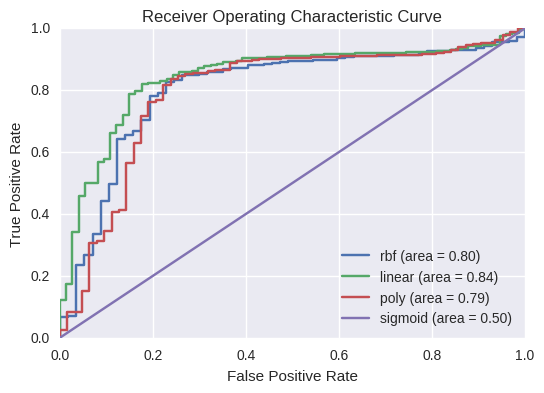

In [23]:
plot_roc(classifier_list=best_svcs)

After looking at the ROC curve above, we select the best estimator based on highest area under the curve.

In [24]:
# Get the areas under the curve
aucs = np.array([x.get('auc') for x in best_svcs])

# Get classifier with most area
best_estimator = best_svcs[np.where(aucs.max())[0][0]]

# Predicted classed by the bestest classifier
predicted_classes = best_estimator.get('predicted_classes')

test_all['predicted'] = predicted_classes

/home/wtgee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
test_all.head()

,amplitude,class,iqr,mag_median,period,predicted,skew
ID,,,,,,,
1126005035409,0.11,1,0.0475,15.190,0.815859,1,0.458680
1129005005886,0.30,1,0.0900,15.680,0.276828,1,1.032698
1009006018898,0.66,1,0.3700,14.270,0.247752,1,0.876586
1140005007210,0.20,1,0.1700,16.465,0.476515,1,-0.184692
1129005028015,0.64,1,0.3500,16.230,0.283300,1,0.763714


### 6. Analysis

We can look at the number that have been misclassified, which will help us determine some properties.

In [26]:
# Get all misclassified entries
misclassified = test_all[test_all['predicted'] != test_all['class']]

length_of_diff = len(misclassified)
length_of_unlabeled = len(unlabeled_classes)

diff_percentage = 1 - (float(length_of_diff)/float(length_of_unlabeled))

print("Total number of miscalssified: {} ({:.2%})".format(len(misclassified), diff_percentage))

Total number of miscalssified: 57 (94.93%)


In [27]:
misclassified.head()

,amplitude,class,iqr,mag_median,period,predicted,skew
ID,,,,,,,
1140005086947,0.42,1,0.0700,15.87,0.538040,2,2.271308
1115006043119,0.34,1,0.0700,13.57,0.603351,2,2.296614
1118006036564,0.23,1,0.1500,17.37,1.272700,2,1.855142
1007006007641,0.37,2,0.1175,15.04,0.342291,1,2.472513
1135005042159,0.33,2,0.1700,15.01,0.404876,1,1.128281


In [28]:
types = { 1: 'EW', 2: 'EA', 3: 'beta Lyrae'}

# How many of each Variable Type do we have
print("Type\t\tTotal Number\tNumber Misclassified\tMisclassified Percent".format())
print("{}".format('-'*77))
for x in range(1,4):

    total_num = len(test_all[test_all['class'] == x])
    
    a = misclassified['class'] == x
    b = misclassified['predicted'] != x
    total_miss = len(misclassified[a & b]) 
    
    percent = total_miss / total_num
    
    print("{:14s}\t{:12d}\t{:20d}\t{:21.2%}".format(types[x],total_num, total_miss, percent))

Type		Total Number	Number Misclassified	Misclassified Percent
-----------------------------------------------------------------------------
EW            	         986	                  12	                1.22%
EA            	         124	                  30	               24.19%
beta Lyrae    	          15	                  15	              100.00%
